# A/B test Analysis: Landing Page Conversion
This split test aims to determine if the new page achieves a **higher conversion rate**. I will try to simulate data for two groups - A and B - and then try to answear the hypotesis: *"After the changes are done in version B, conversion rate will be higher by 10%"*.

**Note:** Full hypothesis with math-behind will be done further down.



##Terms used:
#### **Group A** - control group, old landing page
#### **Group B** - treatment group, new landing page

In [151]:
# 1. Setup & libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

In [2]:
plt.style.use('default') # Clear visuals

In [24]:
# 2. Simulating A/B Testing Data.

np.random.seed(42) # To reproduce results

# Simulation parameters
sample_size = 10000         # Users in each group (yes, I know it seems absurdly large, all good)
base_conversion_rate = 0.10 # Conversion for A (control)
lift = 0.01                 # Expected 1% point increase for B (so 10% relative lift)

In [25]:
# Simulating data for A
group_a_conversions = np.random.choice([0,1], size = sample_size, p = [1-base_conversion_rate, base_conversion_rate])

# Simulating data for B
group_b_conversion_rate = base_conversion_rate + lift
group_b_conversions = np.random.choice([0,1], size = sample_size, p = [1-group_b_conversion_rate, group_b_conversion_rate])

# Creating a DataFrame for the results
ab_data = pd.DataFrame({
    'group' : ['A'] * sample_size + ['B'] * sample_size,
    'converted' : np.concatenate([group_a_conversions, group_b_conversions])
})

In [26]:
# Preview the data
print("First and last 15 rows of A/B test data:")
print(ab_data.head(15))
print(ab_data.tail(15))

First and last 15 rows of A/B test data:
   group  converted
0      A          0
1      A          1
2      A          0
3      A          0
4      A          0
5      A          0
6      A          0
7      A          0
8      A          0
9      A          0
10     A          0
11     A          1
12     A          0
13     A          0
14     A          0
      group  converted
19985     B          1
19986     B          0
19987     B          0
19988     B          0
19989     B          1
19990     B          0
19991     B          0
19992     B          0
19993     B          0
19994     B          1
19995     B          0
19996     B          0
19997     B          0
19998     B          0
19999     B          0


In [70]:
# 3. Data analysis

# Summary statistics by group
summary_df = ab_data.groupby('group')['converted'].agg([
    ('total_users', 'count'),
    ('conversions', 'sum'),
    ('conversion_rate', 'mean')
]).round(4)

# Adding a column for relative improvement (Group A will result in 0.0)
summary_df.loc
a_rate = summary_df.loc['A', 'conversion_rate']
summary_df['relative_improvement'] = ((summary_df['conversion_rate'] / a_rate) - 1)

In [72]:
print("A/B Test Summary Statistics:")
print(summary_df)

A/B Test Summary Statistics:
       total_users  conversions  conversion_rate  relative_improvement
group                                                                 
A            10000          961           0.0961              0.000000
B            10000         1130           0.1130              0.175858


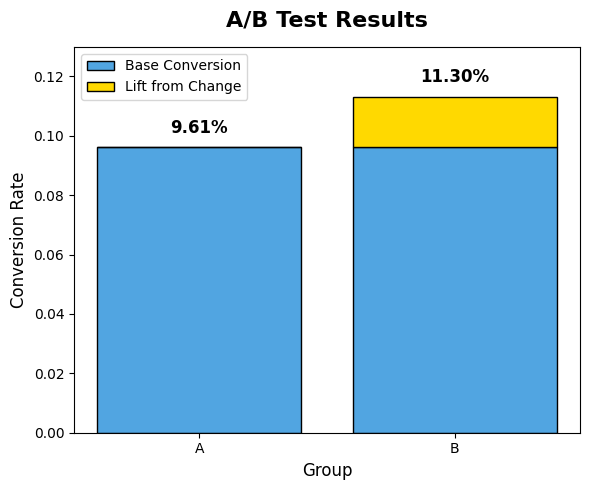

In [61]:
# 3.1 Visualizing Conversion Rates

# MAIN PLOT
plt.figure(figsize=(6, 5))

# I want to show the difference in conversion by coloring the "exessive" part of the group B column
base_rate = summary_df.loc['A', 'conversion_rate']
lift_rate = summary_df.loc['B', 'conversion_rate'] - base_rate

# So now one bar for A, and two bars for B
groups = ['A', 'B']
values_base = [base_rate, base_rate]  # Both bars will use this one
values_lift = [0, lift_rate]          # Group B bar will have the additional bar for lift (or rather the difference between the two)

# Now to plot the base for both
bars_base = plt.bar(groups, values_base, color='#51a5e1', label='Base Conversion',
                    edgecolor='black', linewidth=1)

# And the lift part for B
bars_lift = plt.bar(groups, values_lift, bottom=values_base, color='#ffd900',
                    label='Lift from Change', edgecolor='black', linewidth=1)

plt.title('A/B Test Results', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.ylim(0, max(summary_df['conversion_rate']) * 1.15)

# Annotations with % values for readability

upper_margin = 0.005 # To put the annotation a bit higher

for i, group in enumerate(groups):
    total_height = values_base[i] + values_lift[i]
    plt.text(x=i, y=total_height + upper_margin,
             s=f"{total_height*100:.2f}%",
             ha='center', fontweight='bold', fontsize=12)

# Add a legend to explain the colors
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# **Initial Observations**
Group B shows higher conversion rate, but we need statistical testing.

---

I will use a **Z-test for proportions** to check for statistical significance. For that I need a defined hypothesis:

## - **Null Hypothesis (H₀):** Conversion rate of Group B ≤ Conversion rate of Group A.
*[P(B) - P(A) ≤ 0]*

## - **Alternative Hypothesis (H₁):** Conversion rate of Group B > Conversion rate of Group A.
*[P(B) - P(A) > 0]*





In [73]:
# 4.1 Hypothesis testing - Z-Test

conversions_a = summary_df.loc['A', 'conversions']
users_a = summary_df.loc['A', 'total_users']
conversions_b = summary_df.loc['B', 'conversions']
users_b = summary_df.loc['B', 'total_users']

# First, conversion rates
p_a = conversions_a / users_a
p_b = conversions_b / users_b
p_pooled = (conversions_a + conversions_b) / (users_a + users_b)

# Now to calculate two-proportion Z-Score (im using standard approach: https://en.wikipedia.org/wiki/Two-proportion_Z-test)
se = math.sqrt(p_pooled * (1 - p_pooled) * (1/users_a + 1/users_b))
z_score = (p_b - p_a) / se

# Last thing is the p-value (one-tailed, since I want to show that P(B) > P(A))
p_value = 1 - stats.norm.cdf(z_score)

# Significance level
alpha = 0.05

print("Hypothesis Test Results:")
print(f"Z-score: {z_score:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Significance level: {alpha}")

Hypothesis Test Results:
Z-score: 3.9056
P-value: 0.000047
Significance level: 0.05


In [87]:
# 4.2 Results

if p_value < alpha:
    print(f"Result: Statistically Significant")
    print(f"We reject the null hypothesis (H₀). There is sufficient evidence to conclude that the new landing page (Version B) has a higher conversion rate than the old version (Version A) at a {alpha*100}% significance level.")
else:
    print(f"Result: Not Statistically Significant")
    print(f"We fail to reject the null hypothesis (H₀). There is not enough evidence to conclude that Version B is better than Version A.")

# Calculate the confidence interval for the difference in conversion rates
std_error_diff = math.sqrt((p_a * (1-p_a)/users_a) + (p_b * (1-p_b)/users_b))
margin_of_error = 1.96 * std_error_diff # For 95% CI
ci_low = (p_b - p_a) - margin_of_error
ci_high = (p_b - p_a) + margin_of_error

print(f"\nThe difference in conversion rate (B - A) is: {((p_b - p_a)*100):.2f}% points")
print(f"95% Confidence Interval for the difference: [{ci_low*100:.3f}%, {ci_high*100:.3f}%]")
print(f"Conversion rate in B went up by {((p_b / p_a - 1) * 100):.2f}% comparing with A.")


Result: Statistically Significant
We reject the null hypothesis (H₀). There is sufficient evidence to conclude that the new landing page (Version B) has a higher conversion rate than the old version (Version A) at a 5.0% significance level.

The difference in conversion rate (B - A) is: 1.69% points
95% Confidence Interval for the difference: [0.842%, 2.538%]
Conversion rate in B went up by 17.59% comparing with A.


## **Calculating statistical power**
Let's see the probability of correctly rejecting a false null hypothesis in this case. Since I work with proportions here, I will try to manualy calculate the power, to avoid library interpretation issues.

In [126]:
# 6.1 Statistical Power

# I need some tools form statsmodels
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# First - calculating Cohen's h effect size for proportions
effect_size = proportion_effectsize(prop1 = p_b, prop2 = p_a)
print(f"Cohen's h effect size: {effect_size:.3f}")

# Solve for power
power_analyzer = NormalIndPower()
power = power_analyzer.solve_power(
    effect_size=effect_size,
    nobs1 = users_a,        # Sample size in group A
    alpha = alpha,          # Significance level
    alternative = 'larger'  # One-tailed test
)

print(f"\nStatistical Power of this test: {power:.2%}")


Cohen's h effect size: 0.055

Statistical Power of this test: 98.82%


## Now that is a **massive** statistic power.
That doesn't mean I did it right though, mainly because the sample is just unnecessarly large. Let's find one that gets us around 80% power.

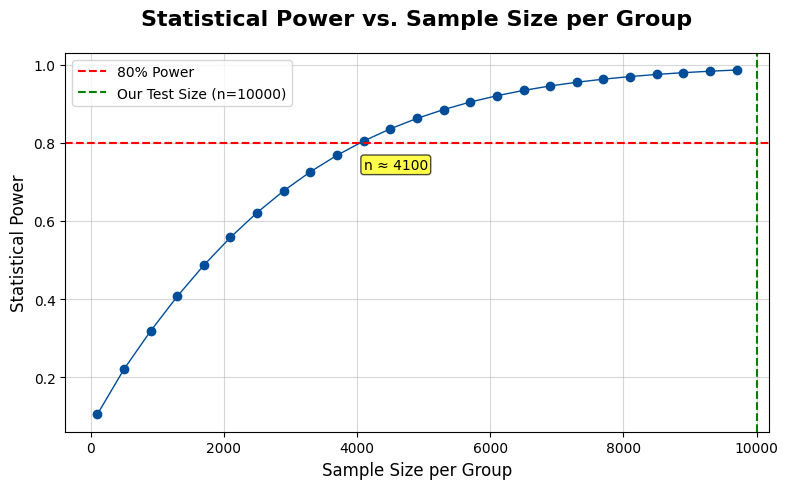

With our actual sample size (n=10000 per group), power = 98.8%
Minimum sample size needed for 80% power: ~4100 users per group


In [150]:
# 6.2 Demonstrate the Impact of Sample Size on Power
# Let's see how the statistical power changes with sample size.

# Define a range of sample sizes to test
sample_sizes = np.arange(100, 10000, 400)  # From 100 to 10,000 users per group, jumping by 400

# Calculate power for each sample size using statsmodels
powers = []
for n in sample_sizes:
    power_n = power_analyzer.solve_power(
        effect_size = effect_size, # So if I want to detect an effect of this size (for 10000) how low can I get with sample count?
        nobs1 = n,
        alpha = alpha,
        alternative='larger'
    )
    powers.append(power_n)

# Power curve plot
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, powers, 'o-', linewidth=1, markersize=6, color = "#004d99")
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Power')
plt.axvline(x=users_a, color='g', linestyle='--', label=f'Our Test Size (n={users_a})')

plt.title('Statistical Power vs. Sample Size per Group', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sample Size per Group', fontsize=12)
plt.ylabel('Statistical Power', fontsize=12)
plt.grid(True, alpha=0.5)
plt.legend()

# Annotation for ~80% power sample
for i, (n, pwr) in enumerate(zip(sample_sizes, powers)):
    if pwr >= 0.8 and (i == 0 or powers[i-1] < 0.8):
        plt.annotate(f'n ≈ {n}', xy=(n, pwr), xytext=(0, -20), textcoords='offset points',
                    bbox=dict(boxstyle="round,pad=0.2", fc="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

print(f"With our actual sample size (n={users_a} per group), power = {power:.1%}")

# Find minimum size for 80% power
try:
    min_size_index = next(i for i, pwr in enumerate(powers) if pwr >= 0.8)
    min_size_for_80 = sample_sizes[min_size_index]
    print(f"Minimum sample size needed for 80% power: ~{min_size_for_80} users per group")
except StopIteration:
    print(">10,000 users per group needed for 80% power.")

## So just as I feared...
Sample size of 10000 per group was an *ultra-bad* shot. But thanks to the analysis above I can tell, that to have ~80% statistical power, I would not need to get 10000 samples per group. Just around 4000 should do It, what a relief.

**Author:** Piotr Zbiński